In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import cv2

In [2]:
# Configuration
BATCH_SIZE = 1024
EPOCHS = 100
LEARNING_RATE = 0.001
ROPE_DIM = 128   # Dimension for each coordinate's RoPE embedding
LINEAR_DIM = 256 # Dimension for each linear layer

In [3]:
def imagenp_open_img(filename:str,BGR2RGB:bool=True) -> np.array:
    """ Abre una imagen desde un archivo. Soporta caracteres internacionales """
    f=open(filename,'rb')
    data=f.read()
    f.close()
    data = np.frombuffer(data, np.uint8)
    img = cv2.imdecode(data,flags=cv2.IMREAD_COLOR)
    if(BGR2RGB): img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    return img

def imagenp_show_image(img, figsize=(6,6),title='',normalize01=False, cmap=None):
    '''Muestra una imagen.
    image = show_image('../misc/panda.jpg',(15,15))

    Args:
        img (str|np.ndarray|PIL.Image.Image): La imagen o ruta del archivo
        figsize (int,int): Dimensiones de la figura de matplotlib.pyplot
        title (str): Titulo de la imagen
        normalize01: Normaliza los datos en el rango [0.0 1.0]
        cmap: 'gray', 'gray_r', 'Accent', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'Dark2', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'Paired', 'Pastel1', 'Pastel2', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Set1', 'Set2', 'Set3', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'tab10', 'tab20', 'tab20b', 'tab20c', 'terrain', 'winter'
    '''
    if isinstance(img,(str|Path)):
        if not title: title = str(img)
        img = imagenp_open_img(img,BGR2RGB=True)

    # if isinstance(img,(PIL.Image.Image)): img = np.array(img)
        
    original_shape = img.shape
    original_dtype = img.dtype
    mini = np.min(img)
    maxi = np.max(img)
        
    if img.shape[-1]<3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
    # if len(img.shape)==4: img = imagenp_grid_images(img)
        
    if normalize01 and maxi > mini: img = (img-mini)/(maxi-mini)
    
    plt.figure(figsize=figsize)
    title += f" {original_shape} {original_dtype} {mini:.1f} {maxi:.1f}"
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()
    
def imagenp_save_image(filename,img, flipBR=True):
    '''Guarda una imagen en disco.
    save_image(img, '../misc/panda.jpg')
    Args:
        filename (str): Nombre del archivo donde guardar la imagen
        img (np.ndarray): La imagen.
    '''
    if(flipBR) and (img.shape[-1]==3): img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename,img)

In [4]:
def pt_module_parameters(module):
    """ Retorna la cantidad de parametros del modulo pytorch """
    pp=0
    for p in list(module.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

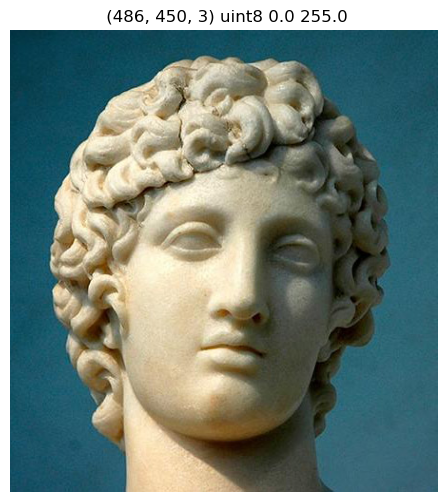

In [5]:
dataset_image = imagenp_open_img("escultura.jpg")
imagenp_show_image(dataset_image)

In [6]:
# Create dataset and dataloader
class CoordinateDataset(Dataset):
    def __init__(self, image=None):
        self.height, self.width, _ = (2048,2048,3) if image is None else image.shape #Si image is None, retorna coordenadas de una imagen de 2048x2048x3
        x_coords = torch.linspace(0, 1, self.width)
        y_coords = torch.linspace(0, 1, self.height)
        x_grid, y_grid = torch.meshgrid(x_coords, y_coords, indexing='xy')        
        self.coords = torch.stack([x_grid.ravel(), y_grid.ravel()], dim=1)
        self.rgb = None if image is None else torch.from_numpy(image).float().view(-1, 3)/255

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        if self.rgb is None: return self.coords[idx] #Retorna solo coordenadas
        return self.coords[idx], self.rgb[idx] #Retorna coordenadas e imagen

In [7]:
dataset = CoordinateDataset(dataset_image)
dataloader  = DataLoader(dataset,             batch_size=BATCH_SIZE, shuffle=True)   #Coordenadas desordenadas para entrenamiento
dataloader2 = DataLoader(dataset,             batch_size=BATCH_SIZE, shuffle=False)  #Coordenadas ordenadas para evaluacion
dataloader3 = DataLoader(CoordinateDataset(), batch_size=BATCH_SIZE, shuffle=False)  #Coordenadas ordenadas para upsampling 2048x2048

In [10]:
dataset[1]

(tensor([0.0022, 0.0000]), tensor([0.0235, 0.2078, 0.2706]))

In [13]:
# Rotary Position Embedding (RoPE) module
class RoPE(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        inv_freq = torch.logspace(0, 3, dim//2) #Valores que multiplican al angulo van desde 1 a 1000 en escala logaritmica
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        # x shape: (batch_size, 2) containing (x, y) coordinates
        x_coords = x[:, 0]
        y_coords = x[:, 1]
        
        x_embed = self._embed_single(x_coords)
        y_embed = self._embed_single(y_coords)
        return torch.cat([x_embed, y_embed], dim=1)

    def _embed_single(self, pos):
        # pos shape: (batch_size,)
        angles = pos.unsqueeze(-1) * self.inv_freq.unsqueeze(0)
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        
        # Interleave sin and cos values
        embed = torch.stack([sin, cos], dim=-1)
        return embed.view(embed.size(0), -1)

In [14]:
# Neural network architecture
class ColorNetRope(nn.Module):
    def __init__(self):
        super().__init__()
        self.rope = RoPE(ROPE_DIM)
        self.layers = nn.Sequential(
            nn.Linear(2 * ROPE_DIM, LINEAR_DIM),
            nn.ReLU(),
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.ReLU(),
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.ReLU(),
            nn.Linear(LINEAR_DIM, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.rope(x)
        return self.layers(x)
    
# Neural network architecture
class ColorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, LINEAR_DIM),
            nn.ReLU(),
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.ReLU(),
            nn.Linear(LINEAR_DIM, LINEAR_DIM),
            nn.ReLU(),
            nn.Linear(LINEAR_DIM, 3),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [21]:
# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ColorNet().to(device)
model = ColorNetRope().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE*0.1)
print(f"Model Parameters: {pt_module_parameters(model)}")

Model Parameters: 198147


In [22]:
# Training loop
train_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * inputs.size(0)
    
    scheduler.step()
    epoch_loss /= len(dataset)
    train_loss.append(epoch_loss)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.6f} LR: {scheduler.get_last_lr()[0]:.6f}')

Epoch 1/100 - Loss: 0.011325 LR: 0.001000
Epoch 2/100 - Loss: 0.002443 LR: 0.000999
Epoch 3/100 - Loss: 0.001606 LR: 0.000998
Epoch 4/100 - Loss: 0.001316 LR: 0.000996
Epoch 5/100 - Loss: 0.001111 LR: 0.000994
Epoch 6/100 - Loss: 0.000987 LR: 0.000992
Epoch 7/100 - Loss: 0.000895 LR: 0.000989
Epoch 8/100 - Loss: 0.000846 LR: 0.000986
Epoch 9/100 - Loss: 0.000790 LR: 0.000982
Epoch 10/100 - Loss: 0.000774 LR: 0.000978
Epoch 11/100 - Loss: 0.000721 LR: 0.000973
Epoch 12/100 - Loss: 0.000669 LR: 0.000968
Epoch 13/100 - Loss: 0.000681 LR: 0.000963
Epoch 14/100 - Loss: 0.000635 LR: 0.000957
Epoch 15/100 - Loss: 0.000605 LR: 0.000951
Epoch 16/100 - Loss: 0.000596 LR: 0.000944
Epoch 17/100 - Loss: 0.000587 LR: 0.000937
Epoch 18/100 - Loss: 0.000558 LR: 0.000930
Epoch 19/100 - Loss: 0.000569 LR: 0.000922
Epoch 20/100 - Loss: 0.000522 LR: 0.000914
Epoch 21/100 - Loss: 0.000531 LR: 0.000906
Epoch 22/100 - Loss: 0.000499 LR: 0.000897
Epoch 23/100 - Loss: 0.000489 LR: 0.000888
Epoch 24/100 - Loss:

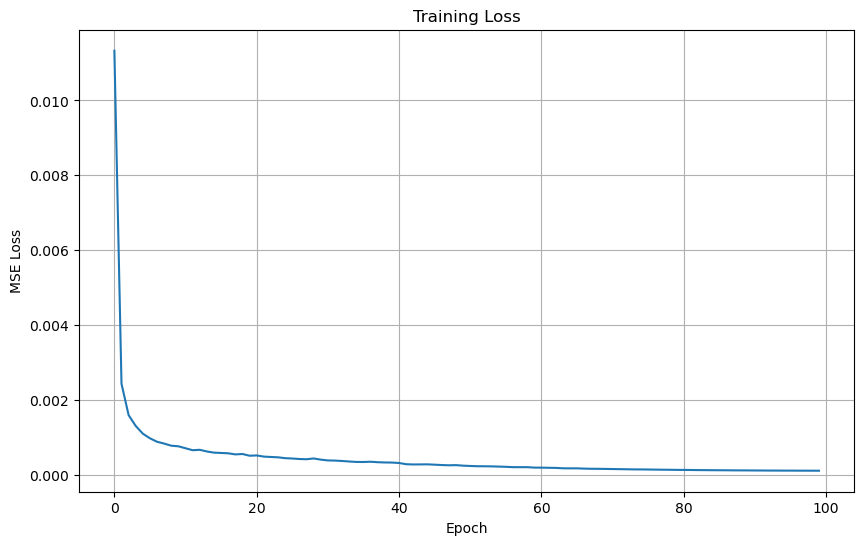

In [23]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.show()

In [24]:
# Calculate final metrics
with torch.no_grad():
    model.eval()
    all_outputs = []
    all_targets = []
    
    for inputs, targets in dataloader2:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_outputs.append(outputs.cpu())
        all_targets.append(targets.cpu())
    
    outputs = torch.cat(all_outputs)
    targets = torch.cat(all_targets)
    
    # Calculate MSE and PSNR
    mse = criterion(outputs, targets)
    psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)
    
    print(f'\nFinal Metrics:')
    print(f'MSE: {mse.item():.6f}')
    print(f'PSNR: {psnr.item():.2f} dB')




Final Metrics:
MSE: 0.000118
PSNR: 39.29 dB


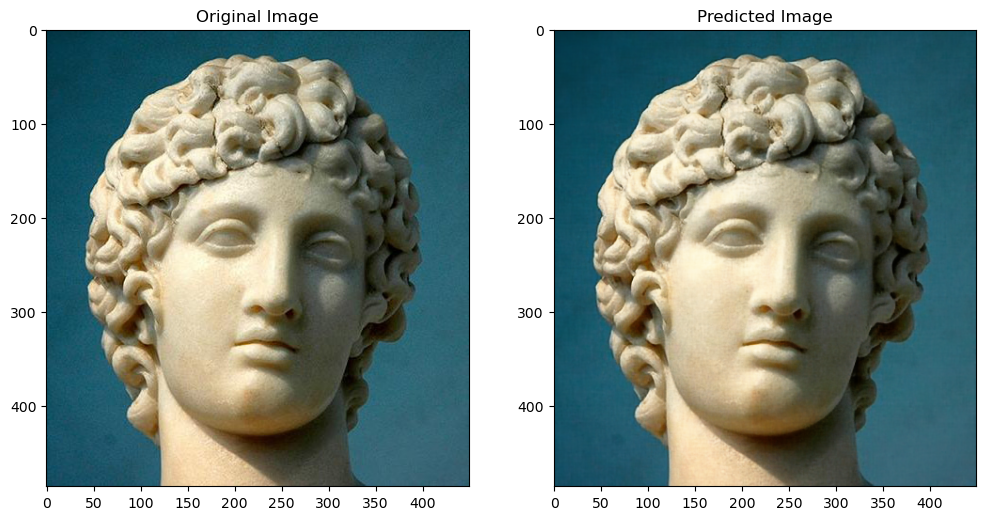

In [25]:
# Visualize results
with torch.no_grad():
    predicted_image = outputs.view(dataset_image.shape[-3], dataset_image.shape[-2], dataset_image.shape[-1]).numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(dataset_image)
ax[0].set_title('Original Image')
ax[1].imshow(predicted_image)
ax[1].set_title('Predicted Image')
plt.show()

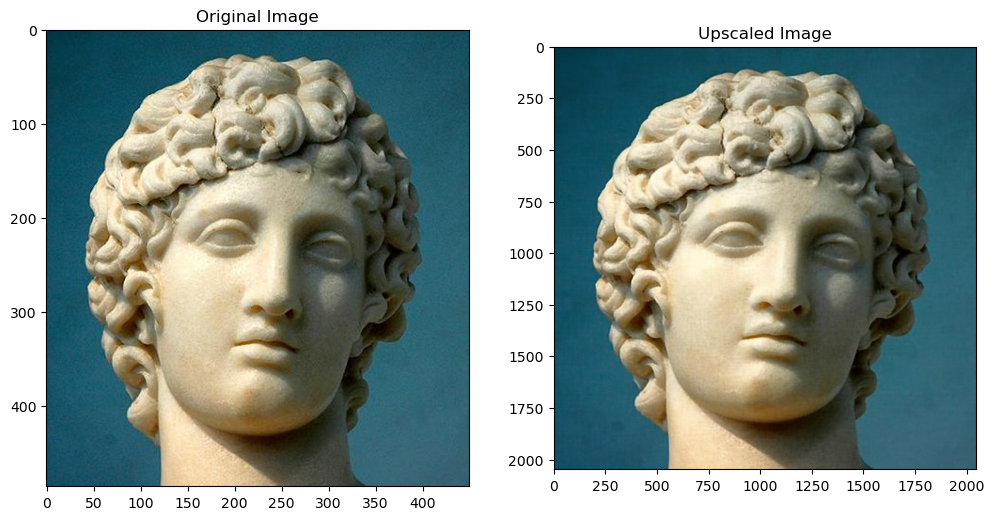

In [26]:
# Calculate final metrics
with torch.no_grad():
    model.eval()
    all_2k = []
    
    for inputs in dataloader3:
        inputs = inputs.to(device)
        outputs = model(inputs)
        all_2k.append(outputs.cpu())
    
    outputs = torch.cat(all_2k)
    predicted_image = outputs.view(2048, 2048, 3).numpy()
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(dataset_image)
ax[0].set_title('Original Image')
ax[1].imshow(predicted_image)
ax[1].set_title('Upscaled Image')
plt.show()
    
    

In [52]:
imagenp_save_image("output02.jpg", (predicted_image*255).astype(np.uint8))